In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
import os, OpenEXR,Imath
from os.path import join

c:\Users\shins\Anaconda3\envs\HyperImaging\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device='cuda'

### Projector(real) intrinsic

In [3]:
# proj params
focal_length_proj = 8e-3
sensor_diag_proj = 5.842e-3
# sensor_width_proj = np.sin(np.arctan2(720,1280))*sensor_diag_proj
sensor_width_proj = np.sin(np.arctan2(720,720))*sensor_diag_proj

N_proj,R,C = 720, 720, 720
proj_pitch = sensor_width_proj/N_proj

### Cam intrinsic

In [4]:
N_cam = 640
sensor_width_cam = 5.32e-3 
focal_length_cam = 16e-3
cam_pitch = sensor_width_cam/N_cam

In [5]:
cam_pitch

8.3125e-06

### Projector sensor coordinate

In [6]:
# proj sensor
xs = torch.linspace(0,R-1, R)
ys = torch.linspace(0,C-1,C)
c, r = torch.meshgrid(xs, ys, indexing='ij')

In [7]:
# projector's x,y,z coords to 실제 단위
x_c, y_c = (r-N_proj/2)*proj_pitch, (c-N_proj/2)*proj_pitch
z_c = torch.zeros_like(x_c)
z_c[:] = -focal_length_proj

# proj_center
proj_center = torch.zeros(size=(4,1))
proj_center[3,0] = 1

# reshape to 720*720
x_c,y_c,z_c = x_c.flatten(), y_c.flatten(), z_c.flatten()

# make projector sensor xyz1 vector
xyz1 = torch.stack((x_c,y_c,z_c, torch.ones_like(x_c)), dim = 1).transpose(0,1)

### Extrinsic Matrices

#### world coord to real proj

In [8]:
# world coordinate to real proj's coordinate

extrinsic_proj_real = torch.zeros((4,4))
# no rotation
extrinsic_proj_real[0,0] = 1 
extrinsic_proj_real[1,1] = 1
extrinsic_proj_real[2,2] = 1

# translate + x 50e-3
extrinsic_proj_real[0,3] = 50e-3 
extrinsic_proj_real[3,3] = 1

In [9]:
extrinsic_proj_real

tensor([[1.0000, 0.0000, 0.0000, 0.0500],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]])

#### real proj to diffraction gratings

In [10]:
# rotation, translation matrix
extrinsic_diff = torch.zeros((4,4))

# rotation
rot = torch.tensor([1,1,1])
extrinsic_diff[0,0] = rot[0]
extrinsic_diff[1,1] = rot[1]
extrinsic_diff[2,2] = rot[2]

# translate
trans = torch.tensor([0,0,10*1e-3])
extrinsic_diff[0,3] = trans[0]
extrinsic_diff[1,3] = trans[1]
extrinsic_diff[2,3] = trans[2]
extrinsic_diff[3,3] = 1

#### real proj to virtual proj (LATER...)

### Change projector sensor to DG coordinate

In [11]:
# change proj sensor to dg coord
xyz_proj_dg = torch.linalg.inv(extrinsic_diff)@xyz1
xyz_proj_dg = xyz_proj_dg[:3]

# change proj center to dg coord
proj_center_dg = torch.linalg.inv(extrinsic_diff)@proj_center
proj_center_dg = proj_center_dg[:3]

In [12]:
xyz_proj_dg[2,:]

tensor([-0.0180, -0.0180, -0.0180,  ..., -0.0180, -0.0180, -0.0180])

### Incident light, intersection points in DG coord

In [13]:
# incident light dir vectors
incident_dir = proj_center_dg - xyz_proj_dg

# make incident dir to unit vector
norm = torch.norm(incident_dir, dim = 0)

# incident light unit dir vector
incident_dir_unit = incident_dir/norm

In [14]:
# find intersection points
def find_intersection(proj_center_dg, incident_dir_unit):
    a = torch.zeros_like(incident_dir_unit)

    for i in range(len(incident_dir_unit[0])):
        t = -proj_center_dg[2,0]/incident_dir_unit[2,i]
        a[:,i] = t*incident_dir_unit[:,i] + proj_center_dg[:,0]
    
    return a

intersection_points = find_intersection(proj_center_dg,incident_dir_unit)
intersection_points = intersection_points.reshape(3,R,C)

### Alpha_m, Beta_m

In [15]:
# alpha_i leaves only x coord
alpha_i = incident_dir_unit[0,:]

# beta_i leaves only y coord
beta_i = incident_dir_unit[1,:]

def get_alpha_m(m, alpha_i, lmbda):
    d = (1/500)*1e-3
    alpha_m = - m*lmbda/d + alpha_i
    
    return alpha_m

def get_beta_m(m, beta_i):
    beta_m = beta_i

    return beta_m

def get_z_m(alpha_m, beta_m):
    z = torch.sqrt(1 - alpha_m**2 - beta_m**2)

    return z

### Find Virtual projector center

In [16]:
# find virtual projector center

def intersect(P,dir):
    """P and dir are NxD arrays defining N lines.
    D is the dimension of the space. This function 
    returns the least squares intersection of the N
    lines from the system given by eq. 13 in 
    http://cal.cs.illinois.edu/~johannes/research/LS_line_intersect.pdf.
    """
    # generate the array of all projectors
    # 3, 640*640 -> 640*640, 3
    projs = np.eye(dir.shape[1]) - dir[:,:,np.newaxis]*dir[:,np.newaxis]  # I - n*n.T
                # 3x3                   # 640*640x3x1     # 640*640x1x3
    # see fig. 1                                # 640*640x3x3

    # generate R matrix and q vector
    R = projs.sum(axis=0) # 3x3
    q = (projs @ P[:,:,np.newaxis]).sum(axis=0) # 열마다 더하기
         # 640*640x3x3      # 640*640x3x1   # 3x1
        # 640*640x3x1
        # 3x1
        
    # solve the least squares problem for the 
    # intersection point p: Rp = q
    p = np.linalg.lstsq(R,q,rcond=None)[0]

    return p

### Distortion function

In [17]:
# distortion function

def distort_func(x, y, p, q, N = 5): # p = p[:,0], q = p[:,1]
    
    cnt=0
    x_d, y_d = torch.zeros_like(x), torch.zeros_like(y)
    
    for n in range(N+1): # 0,1,2,3,4,5
        # for each degree n
        for i in range(n+1):
            # 
            x_d += p[cnt]*(x**(n-i))*(y**(i))
            y_d += q[cnt]*(x**(n-i))*(y**(i))
            cnt += 1
    # x_d = p00 + p10*x + p01*y + p20*(x**2) + p11*x*y + p02*(y**2) + p30*(x**3) + p21*(x**2)*y + p12*x*(y**2) + p03*(y**3) + p40*(x**4) + p31*(x**3)*y + p22*(x**2)*(y**2) + p13*x*(y**3) + p04*(y**4) + p50*(x**5) + p41*(x**4)*y + p32*(x**3)*(y**2) + p23*(x**2)*(y**3) + p14*x*(y**4) + p05*(y**5)
    # y_d = q00 + q10*x + q01*y + q20*(x**2) + q11*x*y + q02*(y**2) + q30*(x**3) + q21*(x**2)*y + q12*x*(y**2) + q03*(y**3) + q40*(x**4) + q31*(x**3)*y + q22*(x**2)*(y**2) + q13*x*(y**3) + q04*(y**4) + q50*(x**5) + q41*(x**4)*y + q32*(x**3)*(y**2) + q23*(x**2)*(y**3) + q14*x*(y**4) + q05*(y**5)

    return x_d, y_d

### Bring Depth

In [18]:
# bring depth
output_dir = "C:/Users/shins/HyperImaging/Dataset/data/result"

def read_exr_as_np(i, rendertype):
        """  Read exr file(rgb rendered obj scene) as numpy array
        
        exr file shape RGBA 640x640x4
        return : numpy array        
        """
        
        fn = os.listdir(output_dir)
        fn = [file for file in fn if rendertype in file]
        
        fn = os.path.join(output_dir, fn[i])

        f = OpenEXR.InputFile(fn)
        channels = f.header()['channels']
 
        dw = f.header()['dataWindow']
        size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

        ch_names = []

        image = np.zeros((size[1], size[0], len(channels)-1))

        for i, ch_name in enumerate(channels):
            ch_names.append(ch_name)
            ch_dtype = channels[ch_name].type
            ch_str = f.channel(ch_name, ch_dtype)

            if ch_dtype == Imath.PixelType(Imath.PixelType.FLOAT):
                np_dtype = np.float32

            image_ch = np.fromstring(ch_str, dtype=np_dtype)
            image_ch.shape = (size[1], size[0])

            if ch_name == "A" :
                continue
            else:
                image[:,:,3-i] = image_ch
        
        return image

def bring_depth(i):
    dist = read_exr_as_np(i,"Depth").astype(np.float32)
    dist = dist[...,0]
    dist = torch.tensor(dist)

    # cam intrinsic
    N = 640
    sensor_width = 5.32e-3 
    focal_length = 16e-3

    x, y = torch.meshgrid(torch.linspace(-sensor_width/2,sensor_width/2,N), torch.linspace(-sensor_width/2,sensor_width/2,N))

    depth = focal_length*dist/(torch.sqrt(x**2 + y**2 + focal_length**2))
    depth *= 10 
    
    return depth

### Unprojection & Projection

In [19]:
# camera sensor to ojbect XYZ (in world coordinate)

def unprojection(depth):
    c,r = torch.meshgrid(torch.linspace(0,N_cam-1,N_cam), torch.linspace(0,N_cam-1,N_cam), indexing='ij') # 행렬 indexing

    x_c, y_c = (r-N_cam/2)*cam_pitch, (c-N_cam/2)*cam_pitch
    z_c = torch.zeros_like(x_c)
    z_c[:] = focal_length_cam

    X,Y,Z = -x_c/focal_length_cam*depth, -y_c/focal_length_cam*depth, -depth

    return X,Y,Z

In [20]:
# project world coordinates onto virtual projector

def projection(X,Y,Z, vproj, focal_length_proj_virtual):
    """
    input : object's XYZ coordinate
            extrinsic matrix of rproj to vproj (vproj)
            focal length of virtual projector
            
    outputs : virtual projector sensor coordinate (in virtual proj's coordinate)
    """
    X,Y,Z = X.flatten(), Y.flatten(), Z.flatten()
    XYZ1 = torch.stack((X,Y,Z,torch.ones_like(X)), dim = 0)

    # XYZ coords in virtual proj's coordinate
    XYZ_vir = torch.linalg.inv(vproj)@torch.linalg.inv(extrinsic_proj_real)@XYZ1
    XYZ_vir = XYZ_vir[:3]
    
    # use triangle similarity ratio
    # xy of virtual proj sensor in virtual proj coordinate
    xy_vproj = (-focal_length_proj_virtual*XYZ_vir[:2,:]/XYZ_vir[2,:])

    return xy_vproj

### Virtual projector sensor coordinate to DG coordinate

In [21]:
# vproj to dg coord
def vproj_to_dg(xy_vproj, vproj, sensor_Z_virtual):
    """
    inputs : virtual projector sensor xy coordinate(virtual proj's coord)
             extrinsic matrix of virtual proj to real proj (vproj)
             
             virtual projector's z coord to make xyz1

    outputs : virtual proj's sensor in DG coord
    """
    ones = torch.ones_like(xy_vproj[0,:])
    z_vproj = torch.zeros_like(xy_vproj[0,:])
    z_vproj[:] = -sensor_Z_virtual.mean()
    
    xyz1_vproj = torch.stack((xy_vproj[0,:], xy_vproj[1,:],z_vproj, ones), dim = 0)

    xyz_dg = torch.linalg.inv(extrinsic_diff)@vproj@xyz1_vproj
    xy_dg = xyz_dg[:2]

    return xy_dg

### DG coordinate to real projector coordinate

In [22]:
def dg_to_rproj(xy_proj):
    """
    inputs : distorted virtual sensor coord = real proj plane coord (xy_proj) in dg coord

    outputs : real proj sensor plane coords in real proj coord
    """
    z_proj = torch.zeros_like(xy_proj[0,:])
    z_proj[:] = -focal_length_proj

    xyz1_proj = torch.stack((xy_proj[0,:], xy_proj[1,:], z_proj, torch.ones_like(xy_proj[0,:])), dim=0)
    
    xy_proj_real = extrinsic_diff@xyz1_proj
    xy_proj_real = xy_proj_real[:2,:]

    return xy_proj_real

### Bring Occlusion

In [23]:
def bring_occlusion(i):
    occlusion = read_exr_as_np(i, "Occlusion").astype(np.float32)
    occlusion = torch.tensor(occlusion)
    occlusion = occlusion.reshape(640*640,3)

    mask_0 = (occlusion[:,:] <= 0.8)  #  0.5보다 작은 숫자들 즉, true 인 곳에 0을 넣기
    mask_1 = (occlusion[:,:] > 0.8)

    occ = np.ma.array(occlusion, mask=mask_0)
    occ = occ.filled(fill_value=0.0)

    occ = np.ma.array(occ, mask=mask_1)
    occ = occ.filled(fill_value=1.0)

    occ = occ.reshape(640,640,3)
    occ = occ[...,0]
    occ = torch.tensor(occ)
    
    return occ

### Bring normal

In [24]:
def bring_normal(i):
    normal = read_exr_as_np(i, "Normal").astype(np.float32)
    normal = torch.tensor(normal)
    normal = normal.reshape(N_cam*N_cam,3).transpose(1,0)

    norm = torch.norm(normal, dim = 0)
    normal_unit = normal/norm
    normal_unit = torch.tensor(normal_unit)
    
    return normal_unit

### Illumination unit vector

In [25]:
def illum_unit(X,Y,Z, optical_center_virtual):
    """ 
    inputs : X,Y,Z world coord
             virtual projector center in dg coord (optical_center_virtual) # need to change it to world coord
    """
    XYZ = torch.stack((X,Y,Z), dim = 0)

    # optical center virtual in dg coord to world coord
    optical_center_virtual = optical_center_virtual.squeeze(dim=0)
    optical_center_virtual1 = torch.stack((optical_center_virtual[0],optical_center_virtual[1],optical_center_virtual[2], torch.tensor([1])), dim = 0)
    optical_center_virtual_world = extrinsic_proj_real@extrinsic_diff@optical_center_virtual1
    optical_center_virtual_world = optical_center_virtual_world[:3]

    XYZ = XYZ.permute(1,2,0)
    optical_center_virtual_world = optical_center_virtual_world.transpose(1,0)
    # illumination vector in world coord
    illum_vec = optical_center_virtual_world - XYZ # 640x640x3
    illum_vec = illum_vec.permute(2,0,1) # 3x640x640

    illum_norm = torch.norm(illum_vec, dim = 0)
    illum_unit = illum_vec/illum_norm
    illum_unit = illum_unit.reshape(3, N_cam*N_cam)

    return illum_unit

### bring illumination

In [26]:
import cv2

def bring_illum():
    illum_path = "C:/Users/shins/HyperImaging/Calibration/patterns/graycode_pattern"
    illum = cv2.imread(os.path.join(illum_path, "pattern_12.png")).astype(np.float32)
    illum = torch.tensor(illum)

    illum = illum.reshape(720*1280,3)

    mask_0 = (illum[:,:] < 150)
    mask_1 = (illum[:,:] >= 150)

    ill = np.ma.array(illum, mask = mask_0)
    ill = ill.filled(fill_value = 0.0)

    ill = np.ma.array(ill, mask= mask_1)
    ill = ill.filled(fill_value = 1.0)

    ill = ill.reshape(720,1280, 3)
    ill = torch.tensor(ill)

    return ill

### Bring hyperspectral texture image

In [27]:
def bring_hyp_img(i):
        ############################# Need to be connected LATER #######################################
        
        img_hyp_text_path = 'C:/Users/shins/OneDrive/문서/GitHub/Scalable-Hyperspectral-3D-Imaging/Dataset/image formation/img_hyp_text/'
        img_list = os.listdir(img_hyp_text_path)
        img_choice = img_list[i]
        hyp_img = np.load(os.path.join(img_hyp_text_path, img_choice)).astype(np.float32)
        hyp_img = torch.tensor(hyp_img) 

        return hyp_img

### Camera Projector CRF

In [28]:
m_list = [-1,0,1]

wvls_int = torch.linspace(400*1e-9, 750*1e-9, 15) # interpolation에 사용된 값
wvls = torch.linspace(400*1e-9, 780*1e-9, 77) # 400 ~ 780 까지 5nm 간격으로
wvls_nm = wvls*1e9
wvls_nm = wvls_nm.long()
wvls_nm # 400 ~ 780 까지 5nm 간격으로 integer

m_N = len(m_list)
wvls_N = len(wvls)

dat_path = './dat/'
if not os.path.exists(dat_path):
    os.makedirs(dat_path)

In [29]:
CRF_cam = np.load('./CRF_cam.npy')
CRF_cam = torch.tensor(CRF_cam)

In [30]:
CRF_proj = np.load('./CRF_proj.npy')
CRF_proj = torch.tensor(CRF_proj)

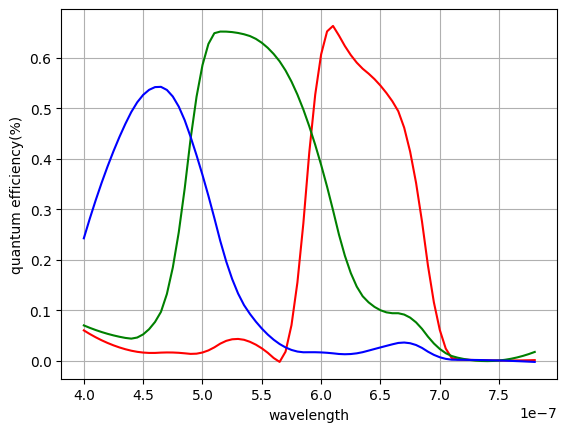

In [31]:
plt.plot(wvls, CRF_cam[:,0], color = 'red')
plt.plot(wvls, CRF_cam[:,1], color = 'green')
plt.plot(wvls, CRF_cam[:,2], color = 'blue')

plt.xlabel('wavelength')
plt.ylabel('quantum efficiency(%)')
plt.grid()
plt.show()

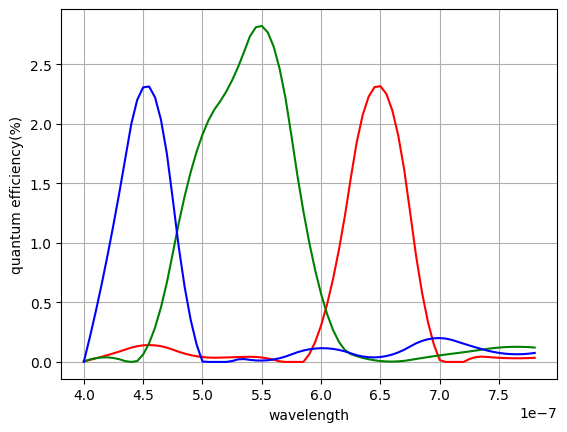

In [32]:
plt.plot(wvls, CRF_proj[:,0], color = 'red')
plt.plot(wvls, CRF_proj[:,1], color = 'green')
plt.plot(wvls, CRF_proj[:,2], color = 'blue')

plt.xlabel('wavelength')
plt.ylabel('quantum efficiency(%)')
plt.grid()
plt.show()

### hyperspectral depth image formation

In [33]:
# # projector RGB illumination image(optimization parameter)
illum = torch.zeros((R,C,3))
# illum[R//4:R//3, C//4:C//3] = 1
# illum[R//3:R//2, C//3:C//2] = 1
# illum[R//2:R//1, C//2:C//1] = 1

# illum[:,0:50] = 1
illum[:,100:150] = 1
# illum[:,200:250] = 1
# illum[:,300:350] = 1
# illum[:,400:450] = 1
# illum[:,500:550] = 1
# illum[:,600:650] = 1
# illum[:,700:] = 1

# # k = 0 100*k + 100*k + 50
# # k = 1 100*k + 100*k + 50
# # k = 2 100 
# # k = 7 일때까지 하기
# # plt.imshow(illum)

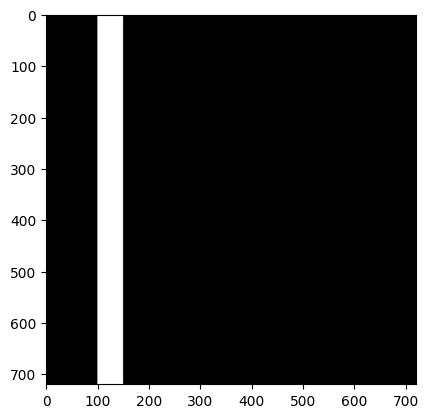

In [34]:
plt.imshow(illum)

In [35]:
# # projector hyperspectral illumination image 
illum_hyp = illum.reshape((R*C, 3))@CRF_proj.T # 720*720, 3 @ 3, 77 -> 720*720, 77
illum_hyp = illum_hyp.reshape((R,C,wvls_N)) # 720, 720, 77 / 각 파장에 대한 reflectance 값

In [36]:
# diffracted illumination image projected to a scene and captured by the camera 
illums_w_occ = torch.zeros((m_N, N_cam, N_cam, wvls_N)) # 3, R, C, 77

In [37]:
N_scene = 1

for k in range(8):
    illum = torch.zeros((R,C,3))
    if k != 7:
        illum[:, 100*k: 100*k + 50] = 1
    else:
        illum[:, 100*k :] = 1

    illum_hyp = illum.reshape((R*C, 3))@CRF_proj.T
    illum_hyp = illum_hyp.reshape((R,C,wvls_N))

    for i in range(N_scene):
        for m_i, m in enumerate(m_list):
            for wvl_i, wvl in enumerate(wvls):

                # compute direction cosines
                alpha_m = get_alpha_m(alpha_i=alpha_i, m=m, lmbda=wvls[wvl_i])
                beta_m = get_beta_m(beta_i=beta_i, m=m)
                z = get_z_m(alpha_m, beta_m)
                
                alpha_m = alpha_m.reshape(R,C)
                beta_m = beta_m.reshape(R,C)
                z = z.reshape(R,C)
                
                # diffracted unit vector
                diffracted_dir_unit = torch.stack((alpha_m,beta_m,z), dim = 0)
                intersection_points_r = intersection_points.reshape(3,R*C)
                diffracted_dir_unit_r = diffracted_dir_unit.reshape(3,R*C)

                # virtual projector pixels 
                sensor_z = xyz_proj_dg[2,:].mean()  # new sensor's z location
                start = [intersection_points_r[0,:],intersection_points_r[1,:],intersection_points_r[2,:]]

                # find virtual proj sensor xyz in dg coordinate
                scale_sensor = (sensor_z-start[2])/z.flatten() 
                sensor_X_virtual = start[0] + scale_sensor*alpha_m.flatten()
                sensor_Y_virtual = start[1] + scale_sensor*beta_m.flatten()
                sensor_Z_virtual = start[2] + scale_sensor*z.flatten()
                
                # optical_center_virtual : virtual project's center in dg coord
                p = intersection_points_r.data.numpy().T
                d = diffracted_dir_unit_r.data.numpy().T
                optical_center_virtual = intersect(p,d)
                optical_center_virtual = torch.tensor(optical_center_virtual, dtype=torch.float32)
                optical_center_proj = proj_center_dg

                # extrinsic matrix of virtual proj(real proj to vir proj)
                extrinsic_proj_virtual = torch.zeros((4,4))
                rot = torch.tensor([1,1,1])
                extrinsic_proj_virtual[0,0] = rot[0]
                extrinsic_proj_virtual[1,1] = rot[1]
                extrinsic_proj_virtual[2,2] = rot[2]
                trans = optical_center_virtual - optical_center_proj
                extrinsic_proj_virtual[0,3] = trans[0]
                extrinsic_proj_virtual[1,3] = trans[1]
                extrinsic_proj_virtual[2,3] = trans[2]
                extrinsic_proj_virtual[3,3] = 1

                # intrinsic of virtual projector : intrinsic_proj_virtual
                focal_length_proj_virtual = (optical_center_virtual[2] - sensor_Z_virtual.mean()).abs()
                cx_proj_virtual = sensor_X_virtual.mean() - optical_center_virtual[0]
                cy_proj_virtual = sensor_Y_virtual.mean() - optical_center_virtual[1]
                intrinsic_proj_virtual = torch.tensor([[focal_length_proj_virtual, 0, cx_proj_virtual], 
                                                        [0, focal_length_proj_virtual, cy_proj_virtual],
                                                        [0,0,1]])
                
                # real coordinates (NOT NEEDED)
                # sensor_X_real = xyz_proj_dg[0,:]
                # sensor_Y_real = xyz_proj_dg[1,:]
                # sensor_Z_real = xyz_proj_dg[2,:]
                
                # depth
                depth = bring_depth(i)

                # unproject to world coord from cam sensor (world coord)
                X,Y,Z = unprojection(depth=depth)

                # project world coord onto vir proj(in Virtual proj coord)
                xy_vproj = projection(X,Y,Z, extrinsic_proj_virtual, focal_length_proj_virtual) # 2x640*640
                # xy_vproj sensor coord in dg coord (to put in distortion function)
                xy_dg = vproj_to_dg(xy_vproj, extrinsic_proj_virtual, sensor_Z_virtual) # 2, 640*640
                
                # map virtual coordinates to real coordinates (in dg coords)
                wvl_item = torch.tensor(wvl.item())
                wvl_item = torch.round(wvl_item*1e9)
                p = loadmat(join(dat_path, 'param_dispersion_coordinates_m%d_wvl%d.mat'%(m, wvl_item)))
                p = p['p']
                # p_dist = torch.tensor(p, dtype=torch.float32, device=device).T
                p_dist = torch.tensor(p, dtype=torch.float32).T
                sensor_X_virtual_distorted, sensor_Y_virtual_distorted = distort_func(xy_dg[0,:], xy_dg[1,:], p_dist[:,0], p_dist[:,1])
                sensor_X_virtual_distorted, sensor_Y_virtual_distorted = -sensor_X_virtual_distorted, -sensor_Y_virtual_distorted

                xy_proj = torch.stack((sensor_X_virtual_distorted, sensor_Y_virtual_distorted), dim=0)

                # change it to real proj coord
                xy_proj_real = dg_to_rproj(xy_proj) # 2, 640*640
                # xy to rc (in real proj coord)
                rc_proj = xy_proj_real/proj_pitch + N_proj/2 # rc_proj_center = N_proj/2?
                rc_proj = rc_proj.transpose(1,0).reshape(N_cam,N_cam,2)

                # check visualization
                # plt.figure(figsize=(10,5))
                # plt.subplot(121), plt.imshow((0<= rc_proj[:,:,0])*(rc_proj[:,:,0] < N_proj)), plt.colorbar()
                # plt.subplot(122), plt.imshow((0<=rc_proj[:,:,1])*(rc_proj[:,:,1]< N_proj)), plt.colorbar()
                # break

                cond = (0<= rc_proj[:,:,0])*(rc_proj[:,:,0] <N_proj)*(0<=rc_proj[:,:,1])*(rc_proj[:,:,1]<N_proj)
                # cond: N_cam , N_cam 
                
                r_proj, c_proj = rc_proj[:,:,1], rc_proj[:,:,0] # N_cam * N_cam
                r_proj_valid, c_proj_valid = r_proj[cond], c_proj[cond] # rc_proj_valid: N_cam_valid, 1

                # illumination
                illum_img = torch.zeros(cond.shape[0], cond.shape[1], wvls_N)

                illum_img_wvli = illum_img[:,:,wvl_i] # illum_hyp : 720,720,77
                hyp =  illum_hyp[r_proj_valid.long(), c_proj_valid.long(), wvl_i]
                # print(hyp.shape) # 300452
                # print(illum_img_wvli.shape) # 640, 640
                illum_img_wvli[cond] = hyp        
                # print(illum_img_wvli.shape) # 640, 640
                illum_img[:,:, wvl_i] = illum_img_wvli

                # multipy with occlusion
                occ = bring_occlusion(i)
                illum_img = illum_img.permute(2,0,1) # 77, 640, 640
                illum_w_occ = illum_img*occ # 77x640x640 * 640x640

                # shading term
                # world coord
                normal_vec_unit = bring_normal(i)
                normal_vec_unit_clip = torch.clip(normal_vec_unit, 0 ,1)
                illum_vec_unit = illum_unit(X,Y,Z, optical_center_virtual) # virtual proj center - XYZ
                shading = (illum_vec_unit*normal_vec_unit_clip).sum(axis = 0)
                shading = shading.reshape(N_cam, N_cam) # 640x640

                # final pattern
                illums_w_occ[m_i, :, :, wvl_i] = illum_w_occ[wvl_i,:,:]*shading

        # image formation 
        # hyp_img = torch.zeros((N_cam, N_cam, len(wvls)), device=device)
        # cam_m_img = torch.zeros((m_N, N_cam, N_cam, 3), device=device)

        hyp_img = bring_hyp_img(i) # N_cam, N_cam, 77
        cam_m_img = torch.zeros((m_N, N_cam, N_cam, 3))
        
        for i in range(m_N):
            cam_m_img[i] = (hyp_img*illums_w_occ[i] @ CRF_cam) # N_cam, N_cam, 77 @ 77, 3 -> 3, N_cam, N_cam, 3

        cam_img = cam_m_img.sum(axis=0) # N_cam, N_cam, 3

        cam_m_img_n = cam_m_img.numpy()
        cam_img_n = cam_img.numpy()
        # cv2.imwrite(f'./result/illum_patt_{k}.jpg', illum)
        cv2.imwrite(f'./result/illum_patt_{k}_m-1.jpg', cv2.cvtColor(cam_m_img_n[0,:,:]*50, cv2.COLOR_RGB2BGR))
        cv2.imwrite(f'./result/illum_patt_{k}_m0.jpg', cv2.cvtColor(cam_m_img_n[1,:,:]*50, cv2.COLOR_RGB2BGR))
        cv2.imwrite(f'./result/illum_patt_{k}_m1.jpg', cv2.cvtColor(cam_m_img_n[2,:,:]*50, cv2.COLOR_RGB2BGR))
        cv2.imwrite(f'./result/illum_patt_{k}_all.jpg', cv2.cvtColor(cam_img_n*50, cv2.COLOR_RGB2BGR))

c:\Users\shins\Anaconda3\envs\HyperImaging\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
c:\Users\shins\Anaconda3\envs\HyperImaging\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor(0.0095)


c:\Users\shins\Anaconda3\envs\HyperImaging\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor(0.2409)
tensor(0.4816)
tensor(0.7314)
tensor(0.9903)
tensor(1.2584)
tensor(1.5357)
tensor(1.8222)
tensor(2.1182)
tensor(2.3401)
tensor(2.5074)
tensor(2.6106)
tensor(2.6496)
tensor(2.6245)
tensor(2.5352)
tensor(2.3818)
tensor(2.2163)
tensor(2.0907)
tensor(2.0050)
tensor(1.9593)
tensor(1.9536)
tensor(2.0644)
tensor(2.1547)
tensor(2.2258)
tensor(2.3074)
tensor(2.4120)
tensor(2.5384)
tensor(2.6689)
tensor(2.7949)
tensor(2.8649)
tensor(2.8703)
tensor(2.8112)
tensor(2.6874)
tensor(2.4990)
tensor(2.2583)
tensor(1.9608)
tensor(1.6472)
tensor(1.3628)
tensor(1.1715)
tensor(1.0494)
tensor(0.9923)
tensor(1.0002)
tensor(1.0732)
tensor(1.2113)
tensor(1.4144)
tensor(1.6826)
tensor(1.9505)
tensor(2.1526)
tensor(2.2889)
tensor(2.3596)
tensor(2.3644)
tensor(2.3035)
tensor(2.1768)
tensor(1.9844)
tensor(1.7263)
tensor(1.4024)
tensor(1.0717)
tensor(0.7931)
tensor(0.5667)
tensor(0.3924)
tensor(0.2702)
tensor(0.2579)
tensor(0.2538)
tensor(0.2442)
tensor(0.2346)
tensor(0.2504)
tensor(0.2577)
tensor(0.2

KeyboardInterrupt: 

In [ ]:
# N_scene = 1
# for i in range(N_scene):
#     for m_i, m in enumerate(m_list):
#         for wvl_i, wvl in enumerate(wvls):

#             # compute direction cosines
#             alpha_m = get_alpha_m(alpha_i=alpha_i, m=m, lmbda=wvls[wvl_i])
#             beta_m = get_beta_m(beta_i=beta_i, m=m)
#             z = get_z_m(alpha_m, beta_m)
            
#             alpha_m = alpha_m.reshape(R,C)
#             beta_m = beta_m.reshape(R,C)
#             z = z.reshape(R,C)
            
#             # diffracted unit vector
#             diffracted_dir_unit = torch.stack((alpha_m,beta_m,z), dim = 0)
#             intersection_points_r = intersection_points.reshape(3,R*C)
#             diffracted_dir_unit_r = diffracted_dir_unit.reshape(3,R*C)

#             # virtual projector pixels 
#             sensor_z = xyz_proj_dg[2,:].mean()  # new sensor's z location
#             start = [intersection_points_r[0,:],intersection_points_r[1,:],intersection_points_r[2,:]]

#             # find virtual proj sensor xyz in dg coordinate
#             scale_sensor = (sensor_z-start[2])/z.flatten()
#             sensor_X_virtual = start[0] + scale_sensor*alpha_m.flatten()
#             sensor_Y_virtual = start[1] + scale_sensor*beta_m.flatten()
#             sensor_Z_virtual = start[2] + scale_sensor*z.flatten()
            
#             # optical_center_virtual : virtual project's center in dg coord
#             p = intersection_points_r.data.numpy().T
#             d = diffracted_dir_unit_r.data.numpy().T
#             optical_center_virtual = intersect(p,d)
#             optical_center_virtual = torch.tensor(optical_center_virtual, dtype=torch.float32)
#             optical_center_proj = proj_center_dg

#             # extrinsic matrix of virtual proj(real proj to vir proj)
#             extrinsic_proj_virtual = torch.zeros((4,4))
#             rot = torch.tensor([1,1,1])
#             extrinsic_proj_virtual[0,0] = rot[0]
#             extrinsic_proj_virtual[1,1] = rot[1]
#             extrinsic_proj_virtual[2,2] = rot[2]
#             trans = optical_center_virtual - optical_center_proj
#             extrinsic_proj_virtual[0,3] = trans[0]
#             extrinsic_proj_virtual[1,3] = trans[1]
#             extrinsic_proj_virtual[2,3] = trans[2]
#             extrinsic_proj_virtual[3,3] = 1

#             # intrinsic of virtual projector : intrinsic_proj_virtual
#             focal_length_proj_virtual = (optical_center_virtual[2] - sensor_Z_virtual.mean()).abs()
#             cx_proj_virtual = sensor_X_virtual.mean() - optical_center_virtual[0]
#             cy_proj_virtual = sensor_Y_virtual.mean() - optical_center_virtual[1]
#             intrinsic_proj_virtual = torch.tensor([[focal_length_proj_virtual, 0, cx_proj_virtual], 
#                                                     [0, focal_length_proj_virtual, cy_proj_virtual],
#                                                     [0,0,1]])
            
#             # real coordinates (NOT NEEDED)
#             # sensor_X_real = xyz_proj_dg[0,:]
#             # sensor_Y_real = xyz_proj_dg[1,:]
#             # sensor_Z_real = xyz_proj_dg[2,:]
            
#             # depth
#             depth = bring_depth(i)

#             # unproject to world coord from cam sensor (world coord)
#             X,Y,Z = unprojection(depth=depth)

#             # project world coord onto vir proj(in Virtual proj coord)
#             xy_vproj = projection(X,Y,Z, extrinsic_proj_virtual, focal_length_proj_virtual) # 2x640*640
#             # xy_vproj sensor coord in dg coord (to put in distortion function)
#             xy_dg = vproj_to_dg(xy_vproj, extrinsic_proj_virtual, sensor_Z_virtual) # 2, 640*640
            
#             # map virtual coordinates to real coordinates (in dg coords)
#             wvl_item = torch.tensor(wvl.item())
#             wvl_item = torch.round(wvl_item*1e9)
#             p = loadmat(join(dat_path, 'param_dispersion_coordinates_m%d_wvl%d.mat'%(m, wvl_item)))
#             p = p['p']
#             # p_dist = torch.tensor(p, dtype=torch.float32, device=device).T
#             p_dist = torch.tensor(p, dtype=torch.float32).T
#             sensor_X_virtual_distorted, sensor_Y_virtual_distorted = distort_func(xy_dg[0,:], xy_dg[1,:], p_dist[:,0], p_dist[:,1])
#             sensor_X_virtual_distorted, sensor_Y_virtual_distorted = -sensor_X_virtual_distorted, -sensor_Y_virtual_distorted
#             xy_proj = torch.stack((sensor_X_virtual_distorted, sensor_Y_virtual_distorted), dim=0)

#             # change it to real proj coord
#             xy_proj_real = dg_to_rproj(xy_proj)
#             # xy to rc (in real proj coord)
#             rc_proj = xy_proj_real/proj_pitch + N_proj/2 # rc_proj_center = N_proj/2?
#             rc_proj = rc_proj.transpose(1,0).reshape(N_cam,N_cam,2)

#             # # check visualization
#             # plt.figure(figsize=(10,5))
#             # plt.subplot(121), plt.imshow((0<= rc_proj[:,:,0])*(rc_proj[:,:,0] < N_proj)), plt.colorbar()
#             # plt.subplot(122), plt.imshow((0<=rc_proj[:,:,1])*(rc_proj[:,:,1]< N_proj)), plt.colorbar()

#             cond = (0<= rc_proj[:,:,0])*(rc_proj[:,:,0] <N_proj)*(0<=rc_proj[:,:,1])*(rc_proj[:,:,1]<N_proj)
#             # cond: N_cam * N_cam 
#             r_proj, c_proj = rc_proj[:,:,1], rc_proj[:,:,0] # N_cam * N_cam
#             r_proj_valid, c_proj_valid = r_proj[cond], c_proj[cond] # rc_proj_valid: N_cam_valid, 1

#             # illumination
#             illum_img = torch.zeros(cond.shape[0], cond.shape[1], wvls_N)

#             illum_img_wvli = illum_img[:,:,wvl_i]
#             hyp =  illum_hyp[r_proj_valid.long(), c_proj_valid.long(), wvl_i]
#             illum_img_wvli[cond] = hyp            
#             illum_img[:,:, wvl_i] = illum_img_wvli

#             # multipy with occlusion
#             occ = bring_occlusion(i)
#             illum_img = illum_img.permute(2,0,1)
#             illum_w_occ = illum_img*occ # 77x640x640 * 640x640
            
#             # shading term
#             # world coord
#             normal_vec_unit = bring_normal(i)
#             illum_vec_unit = illum_unit(X,Y,Z, optical_center_virtual) # virtual proj center - XYZ
#             shading = (illum_vec_unit*normal_vec_unit).sum(axis = 0)
#             shading = shading.reshape(N_cam, N_cam) # 640x640

#             # final pattern
#             illums_w_occ[m_i, :, :, wvl_i] = illum_w_occ[wvl_i,:,:]*shading

#     # image formation 
#     # hyp_img = torch.zeros((N_cam, N_cam, len(wvls)), device=device)
#     # cam_m_img = torch.zeros((m_N, N_cam, N_cam, 3), device=device)

#     hyp_img = bring_hyp_img(i) # N_cam, N_cam, 77
#     cam_m_img = torch.zeros((m_N, N_cam, N_cam, 3))
    
#     for i in range(m_N):
#         cam_m_img[i] = (hyp_img*illums_w_occ[i] @ CRF_cam)

#     cam_img = cam_m_img.sum(axis=0)

In [38]:
cam_m_img[0,:,:].max()

tensor(11.9928)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


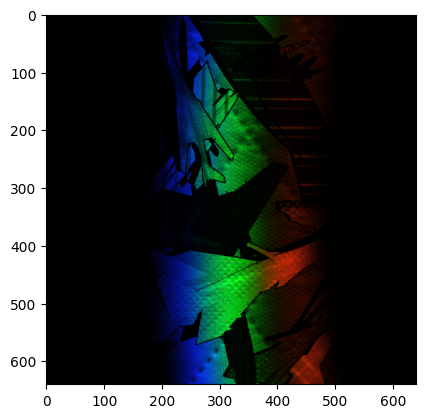

In [39]:
plt.imshow(cam_m_img[0,:,:]/10)

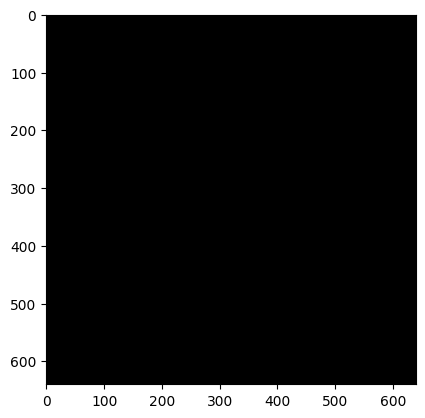

In [40]:
plt.imshow(cam_m_img[1,:,:])

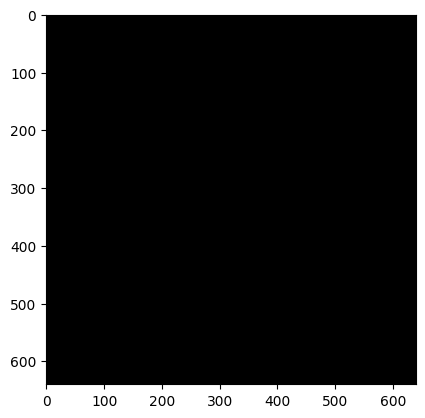

In [41]:
plt.imshow(cam_m_img[2,:,:]/5)

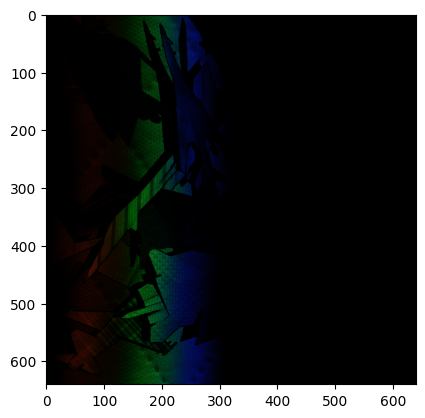

In [ ]:
plt.imshow(cam_img/10)